I've noticed that iirnotch filtering leads to weird boundary effects. And especially since I'm interested in looking trying to segment out the fm part as exactly as possible Im thinking of alternate appproaches. 

### The current method : notch-filter based segmentation
The current approach in version 0.0.22 is to take the bat call, notch filter out the CF and then do peak detection. The peaks detected are assumed to be the FM peaks and a bunch of  samples around the peaks are separated into the call. There's a couple of problems with this  approach:

1) The iir notch filter does some weird things when the call selection is tight, and even in general - there're weird boundary effects. This is  not good because it increases the chances of a false positive FM peak detection. The best example I can give is that even then there is a pure  tone test input (without FM), there are still two peaks input at the edges  of  the pure tone. This is odd behaviour and I don't like it very  much. 

2) The segmented FM peaks are already quite filtered. Even though the notch filter is known for its high selectivity, there is still a few to tens  of kiloHertz that get filtered out from the FM portions. What I'd like  is for a way to identify the CF parts reliably first. 

### Alternate approach #1 : peak frequency amplification and energy difference calculation
This method is basically going to involve the design of a custom FIR that amplifies exactly one frequency. This FIR will be run filtfilt style and the resulting audio will have only the CF part amplified. The energy profile of the CF-amplified call is then subtracted from the energy profile of the non-amplified call, which will then reveal the CF. 

In [1]:
%matplotlib notebook

In [2]:
import sys 
sys.path.append('../measure_horseshoe_bat_calls/')
import scipy.signal as signal 
import matplotlib.pyplot as plt
import numpy as np 


In [3]:
from measure_a_horseshoe_bat_call import make_one_CFcall, rms, dB, moving_rms

In [112]:
fs = 250000
peak_frequency = 100*10**3
fm_durn = 0.002
audio = make_one_CFcall(0.050, 0.002, peak_frequency, fs,call_shape='staplepin', fm_bandwidth=2000)
audio *= signal.tukey(audio.size, 0.1)

/home/autumn/anaconda3/envs/horseshoebat/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


In [113]:
audio_w_noise = np.random.normal(0,10**(-80/20),audio.size+500)
audio_w_noise[250:-250] += audio

<IPython.core.display.Javascript object>


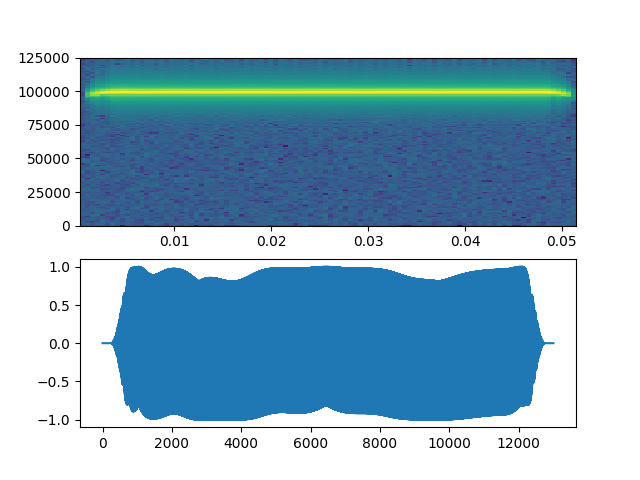

In [114]:
plt.figure()
plt.subplot(211)
plt.specgram(audio_w_noise,Fs=250000);
plt.subplot(212)
plt.plot(audio_w_noise)

In [128]:
# design peak amplifier 
filter_size = 250
freqs = np.fft.rfftfreq(filter_size, 1/fs)
freqs[-1] = fs*0.5
freq_gain = np.ones(freqs.size)
freq_gain[np.argmin(abs(freqs-peak_frequency))] = 20 # amplify only the peak frequency
freq_gain[-1] = 0
peak_amp = signal.firwin2(filter_size, freqs, freq_gain, fs=fs)

<IPython.core.display.Javascript object>


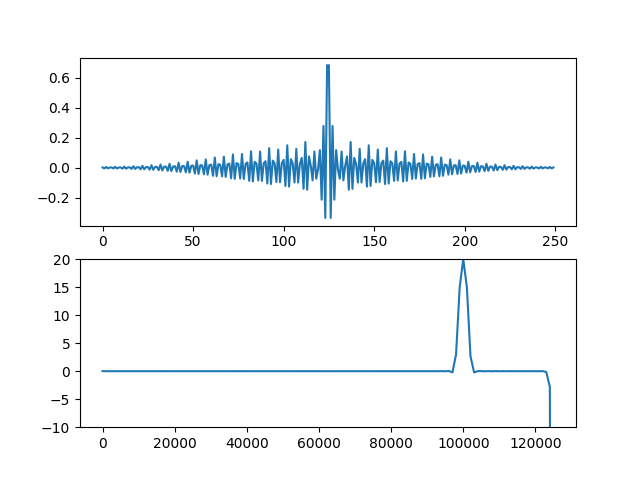

/home/autumn/anaconda3/envs/horseshoebat/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-10, 20)

In [129]:
plt.figure()
plt.subplot(211)
plt.plot(peak_amp)
plt.subplot(212)
plt.plot(freqs, dB(np.fft.rfft(peak_amp)))
plt.ylim(-10,20)

In [130]:
# filter signal left an right to amplify peak frequency
zeropad_samples = 1000
peak_amp_zeropad = np.pad(audio_w_noise, pad_width=zeropad_samples,mode='constant', constant_values=0 )
peakamp_audio = signal.convolve(peak_amp_zeropad,peak_amp,'same')
peakamp_audio = peakamp_audio[zeropad_samples:-zeropad_samples]

In [131]:
dyn_range = [dB(np.max(abs(audio_w_noise)))-20, dB(np.max(abs(audio_w_noise)))- 90]

<IPython.core.display.Javascript object>


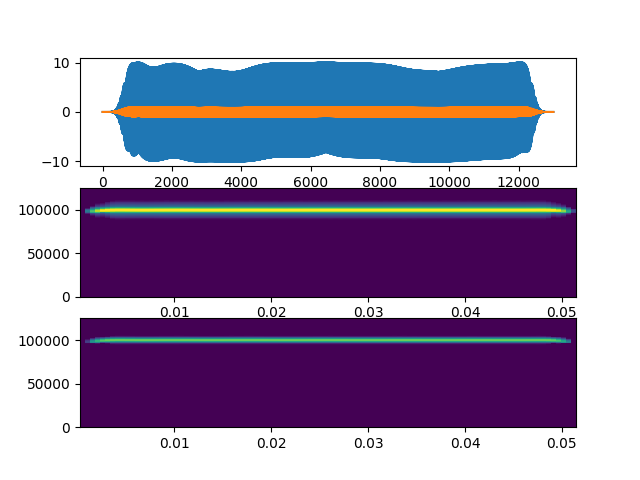

In [132]:
plt.figure()
plt.subplot(311)
plt.plot(peakamp_audio)
plt.plot(audio_w_noise)
plt.subplot(312)
plt.specgram(peakamp_audio, Fs=fs, vmax=dyn_range[0], vmin=dyn_range[1]);
plt.subplot(313)
plt.specgram(audio_w_noise, Fs=fs, vmax=dyn_range[0], vmin=dyn_range[1]);

<IPython.core.display.Javascript object>


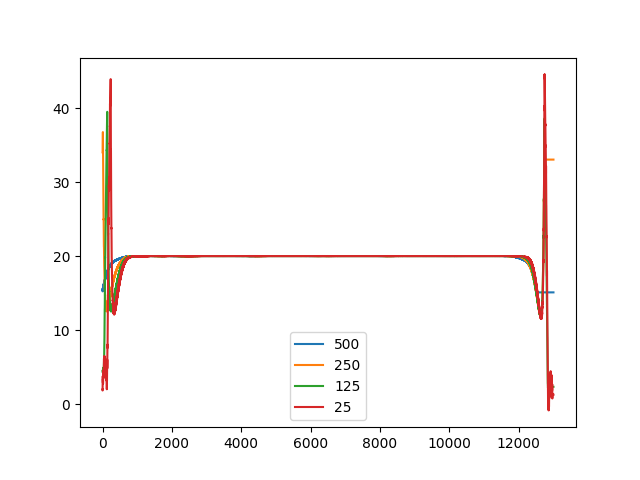

In [133]:
plt.figure()
for winsize in [500, 250, 125, 25]:
    cf_amped_energy  = moving_rms(peakamp_audio, window_size=winsize)
    cf_call_energy = moving_rms(audio_w_noise, window_size=winsize)
    diff_energy = cf_amped_energy/cf_call_energy
    plt.plot(dB(diff_energy), label=winsize)
    #plt.hlines(np.max(dB_diffenergy), 0, dB_diffenergy.size)
    #plt.hlines(np.max(dB_diffenergy)-10, 0,  dB_diffenergy.size)
plt.legend()